In [1]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import os

## Creating dataframes

In [2]:
STATIC_PATH = '/home/elinha/NLP/moducon_data/phase_2'

china_file_name = 'intern_review_china.csv'
japan_file_name = 'intern_review_japan.csv'
korea_file_name = 'intern_review_korea.csv'
northAmerica_file_name = 'intern_review_northAmerica.csv'
color_list = ['ffda11', 'BC002D', '0F64CD', 'B31942']
file_name_list = [china_file_name, japan_file_name, korea_file_name, northAmerica_file_name]


df_dict = {
    file_name.split('_')[-1].split('.')[0]: {
        "dataframe": pd.read_csv(os.path.join(STATIC_PATH, file_name)),
        "color": color
    }
    for color, file_name in zip(color_list, file_name_list)
}

# create target_dict to add data
target_dict = {}


for country in ['china', 'japan', 'korea']:
    target_dict[country] = {
        'dataframe': df_dict[country]['dataframe'],
        'color': df_dict[country]['color']
    }

# create dataframe for east asian countries
orient_df = pd.concat([df_dict[country]['dataframe'] for country in ['china', 'japan', 'korea']])
target_dict['orient'] = {
    'dataframe': orient_df,
    'color': 'ff7f00'  # 동양을 나타내는 회색 추가 (필요에 따라 색상 변경 가능)
}

# add dataframe for North American data  
if 'northAmerica' in df_dict:
    north_america_df = df_dict['northAmerica']['dataframe'].rename(columns={'splited_sentence': 'SeparatedSentences'})
    target_dict['northAmerica'] = {
        'dataframe': north_america_df,
        'color': df_dict['northAmerica']['color']
    }



/tmp/ipykernel_499188/2625491785.py:16: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  "dataframe": pd.read_csv(os.path.join(STATIC_PATH, file_name)),


## Preprocessing

In [3]:
target_country = 'china'  #japan, korea, northAmerica
target_df = df_dict[target_country]['dataframe']

In [5]:
import nltk
from nltk.tokenize import word_tokenize
from nltk import pos_tag

from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import wordnet as wn


nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('tagsets')
nltk.help.upenn_tagset('WRB')

from nltk.data import load
tagdict = load('help/tagsets/upenn_tagset.pickle')
tagdict.keys()

#remain only nouns and adjectives
include_tags = ['JJ', 'JJR', 'JJS', 'NN', 'NNS', 'NNP', 'NNPS']

WRB: Wh-adverb
    how however whence whenever where whereby whereever wherein whereof why


[nltk_data] Downloading package wordnet to /home/elinha/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/elinha/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/elinha/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package tagsets to /home/elinha/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!


In [6]:
target_df = target_df.dropna(subset=['SeparatedSentences'])

# Pycontractions doesn't work due to dependency issue. I just modulized it by myself.

from contractions import expand_contractions

contracted_list = []
Sentences = target_df['SeparatedSentences'].copy()

for sentence in Sentences:
    expanded_sentence = expand_contractions(sentence)
    contracted_list.append(expanded_sentence)
    
# Transform all sentences into lower case! easy!
contracted_list = [text.lower() for text in contracted_list]

# Change numbers into words
import inflect
p = inflect.engine()


def replace_number(match):
    number = match.group()
    return p.number_to_words(number)
    
def convert_number(text):
    converted_text = re.sub(r'\d+', replace_number, text)
    return converted_text

inflected_list = []
inflected_list = [convert_number(text) for text in contracted_list]      

# Remove punctuations
rm_punctionations = inflected_list.copy()

def rm_punct(text):
    cleaned_text = re.sub(r'[!"#$%&\'()*+,-./:;<=>?@[\]。^_`{|}…~]', ' ', text)
    return cleaned_text

rm_punctionations = [rm_punct(text) for text in rm_punctionations]   


# remove japanese, korean, chinese words

def only_english(text):
    cleaned_text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    return cleaned_text

rm_punctionations = [only_english(text) for text in rm_punctionations]


# Invert Text into tokens and POS tags
def pos_tagging(text):
    word_tokens = word_tokenize(text)
    return pos_tag(word_tokens)

tag_sentence = rm_punctionations.copy()

tag_sentence = [pos_tagging(text) for text in tag_sentence]


def remain_specific_tags(tagged_sentence, include_tags):
    return [word for word, tag in tagged_sentence if tag in include_tags]

tag_rm = tag_sentence.copy()
tag_rm = [remain_specific_tags(text, include_tags) for text in tag_rm]
tag_rm_sentence = [pos_tag(sentence) for sentence in tag_rm]

# Lemmatize & remove stopwords
# inflect engine initialize
p = inflect.engine()

# WordNetLemmatizer initialize
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wn.ADJ
    elif treebank_tag.startswith('N'):
        return wn.NOUN
    else:
        return None

def singularize_and_lemmatize(tagged_words):
    new_words = []
    
    for word, tag in tagged_words:
        if tag.startswith('N'):
            singular_word = p.singular_noun(word)
            if singular_word:
                new_words.append(singular_word)
            else:
                new_words.append(word)
        else:
            wn_tag = get_wordnet_pos(tag)
            if wn_tag is not None:
                lemma_word = lemmatizer.lemmatize(word, wn_tag)
                new_words.append(lemma_word)
            else:
                new_words.append(word)
    
    return new_words


# stopwords
def remove_verbs(words):
    
    verbs_to_remove = {
        "i", "you", "they", "them", "your", "my", "he", "him", "his","her","she", "yours","their","hers", 
        'movie', 'movies', 'prada', 'ending', 'cast', 'fashion', 'actor', 'comedy', 'devil', 'scene', 'subtitles',
        'thing', 'other', 'character', 'such', 'lot', "s"
        }
    filtered_words = [word for word in words if word not in verbs_to_remove]
    return filtered_words
processed_sentences = [singularize_and_lemmatize(sentence) for sentence in tag_rm_sentence]
processed_sentences_no_stopwords = [remove_verbs(word) for word in processed_sentences]

# correct actors' or characters' names
def replace_words(sentence):
    replacements = {
        r'\binternben\b': ['intern', 'ben'],
        r'\bexperiencesben\b': ['experience', 'ben'],
        r'\bbeingben\b': ['being', 'ben'],
        r'\bbentwo\b': ['ben', 'two'],
        r'\bbens\b': ['ben'],
        r'\bitben\b': ['it', 'ben'],
        r'\bheartben\b': ['heart', 'ben'],
        r'\botherben\b': ['other', 'ben'],
        r'\bbentheir\b': ['ben', 'their'],
        r'\bfamilyben\b': ['family', 'ben'],
        r'\bfunben\b': ['fun', 'ben'],
        r'\binternrobert\b': ['intern', 'robert'],
        r'\buprobert\b': ['up', 'robert'],
        r'\brealisticrobert\b': ['realistic', 'robert'],
        r'\btemperrobert\b': ['temper', 'robert'],
        r'\bplacerobert\b': ['place', 'robert'],
        r'\btimesrobert\b': ['time', 'robert'],
        r'\bniros\b': ['niro'],
        r'\bdeniro\b': ['niro'],
        r'\bniroi\b': ['niro', 'I'],
        r'\bmyershe\b': ['she'],
        r'\bmyersworking\b': ['working'],
        r'\banhathaway\b': ['hathaway'],
        r'\bsceneanhathaway\b': ['scene', 'hathaway'],
        r'\banhathawayhis\b': ['hathaway', 'his'],
        r'\bhathawayde\b': ['hathaway', 'de'],
        r'\bhathaways\b': ['hathaway'],
        r'\banhathaways\b': ['hathaway'],
        r'\brottenanhathaway\b': ['rotten', 'hathaway'],
        r'\btherejules\b': ['there', 'jule'],
        r'\bweakjule\b': ['weak', 'jule'],
        r'\bjules\b': ['jule'],
        r'\broutinejule\b': ['routine', 'jule'],
        r'\bagejule\b': ['age', 'jule'],
        r'\bbenjamin\b': ['ben'],
        r'\bturnben\b': ['turn', 'ben'],
        r'\bbenmansay\b': ['ben', 'man', 'say'],
        r'\bbenis\b': ['ben', 'is'],
        r'\bbenmaji\b': ['ben', 'maji'],
        r'\bbenbambam\b': ['ben', 'bambam'],
        r'\bbengentleman\b': ['ben', 'gentleman'],
        r'\bgentorben\b': ['gentle', 'ben'],
        r'\brobertdeniro\b': ['robert'],
        r'\bmovierobert\b': ['movie', 'robert'],
        r'\brobertdeniel\b': ['robert'],
        r'\brobertdenilo\b': ['robert'],
        r'\broberto\b': ['robert'],
        r'\bpiecerobert\b': ['piece', 'robert'],
        r'\broberts\b': ['robert'],
        r'\bbutjule\b': ['but', 'jule'],
        r'\brojule\b': ['jule'],
        r'\bannehathaway\b': ['hathaway'],
        r'\bmyloveanne\b': ['my', 'love', 'hathaway'],
        r'\bunhathaway\b': ['hathaway'],
        r'\banahathaway\b': ['hathaway']
    }
    for pattern, replacement in replacements.items():
        sentence = re.sub(pattern, ' '.join(replacement), sentence)

    return sentence.split()

modified_sentences = [replace_words(' '.join(sentence)) for sentence in processed_sentences_no_stopwords]

# remove empty list, remove words with len=1
modified_sentences = [sentence for sentence in modified_sentences if len(sentence) > 1]


# grouping words that should be corrected in the same word
word_groups = [
    ["ben", "bambam",'whitaker', 'whittaker', 'van'],
    ['deniro', 'niro', 'robert'],
    ["anhathaway", "anne", 'hathaway', 'ann'],
    ['jules', 'jule', 'jale', 'julie']
]

word_mapping = {}
for group in word_groups:
    for word in group[1:]:
        word_mapping[word] = group[0]
        
def apply_mapping(sentence):
    return [word_mapping.get(word.lower(), word) for word in sentence]

modified_sentences = [apply_mapping(sentence) for sentence in modified_sentences]

lengths = [len(sentence) for sentence in modified_sentences]

# sentence lenths discriptive analysis
median = np.median(lengths)
mean = np.mean(lengths)
percentile_75 = np.percentile(lengths, 75)
percentile_90 = np.percentile(lengths, 90)
percentile_95 = np.percentile(lengths, 95)

print ('median: ', median, 
       'mean: ', mean, 
       'per_75: ', percentile_75, 
       'per_90: ', percentile_90, 
       'per_95: ', percentile_95)

#wordcloud
from wordcloud import WordCloud
text_data_china = " ".join([" ".join(list(set(sentence))) for sentence in modified_sentences])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_data_china)

from collections import Counter
all_words = [word for sentence in modified_sentences for word in sentence if len(word) > 1]
word_freq= Counter(all_words)

df_word_freq = pd.DataFrame(word_freq.items(), columns=['Word', 'Frequency'])

df_word_freq.head(20)

frequency_mean = df_word_freq['Frequency'].mean()
print('frequency_mean', frequency_mean)
df_word_freq_new = df_word_freq[df_word_freq['Frequency']>frequency_mean]
df_word_freq_new.sort_values(by='Frequency', ascending=False, inplace=True)


words_to_keep = set(df_word_freq_new['Word'])

modified_sentences_filtered = [
    [word for word in sentence if word in words_to_keep]
    for sentence in modified_sentences
]

median:  9.0 mean:  11.325552313463943 per_75:  16.0 per_90:  24.0 per_95:  28.0
frequency_mean 7.60140252454418


/tmp/ipykernel_499188/3751744002.py:252: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_word_freq_new.sort_values(by='Frequency', ascending=False, inplace=True)


In [8]:
import pandas as pd
import numpy as np
import re
from nltk import word_tokenize, pos_tag
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer
import inflect
from collections import Counter
from wordcloud import WordCloud
from contractions import expand_contractions

# All_functions_collection
# expand_contractions, convert_number, rm_punct, only_english, pos_tagging, remain_specific_tags, singularize_and_lemmatize, remove_verbs, replace_words

def preprocess_dataframe(df):
    sentences = df['SeparatedSentences'].dropna().copy()
    
    contracted_list = [expand_contractions(sentence.lower()) for sentence in sentences]
    inflected_list = [convert_number(text) for text in contracted_list]
    rm_punctionations = [only_english(rm_punct(text)) for text in inflected_list]
    tag_sentence = [pos_tagging(text) for text in rm_punctionations]
    tag_rm = [remain_specific_tags(text, include_tags) for text in tag_sentence]
    tag_rm_sentence = [pos_tag(sentence) for sentence in tag_rm]
    processed_sentences = [singularize_and_lemmatize(sentence) for sentence in tag_rm_sentence]
    processed_sentences_no_stopwords = [remove_verbs(word) for word in processed_sentences]
    modified_sentences = [replace_words(' '.join(sentence)) for sentence in processed_sentences_no_stopwords]
    
    modified_sentences = [sentence for sentence in modified_sentences if len(sentence) > 1]
    modified_sentences = [apply_mapping(sentence) for sentence in modified_sentences]
    
    # Remain the only words appeared above the mean frequency
    all_words = [word for sentence in modified_sentences for word in sentence if len(word) > 1]
    word_freq = Counter(all_words)
    df_word_freq = pd.DataFrame(word_freq.items(), columns=['Word', 'Frequency'])
    frequency_mean = df_word_freq['Frequency'].mean()
    words_to_keep = set(df_word_freq[df_word_freq['Frequency'] > frequency_mean]['Word'])
    
    modified_sentences_filtered = [
        [word for word in sentence if word in words_to_keep]
        for sentence in modified_sentences
    ]
    
    return modified_sentences_filtered

# update target_dict
for key in target_dict.keys():
    if key != 'orient':  # for each countries
        target_dict[key]['modified_sentences'] = preprocess_dataframe(target_dict[key]['dataframe'])
    else:  # for 'orient'
        orient_sentences = []
        for country in ['china', 'japan', 'korea']:
            orient_sentences.extend(target_dict[country]['modified_sentences'])
        target_dict['orient']['modified_sentences'] = orient_sentences

# Results
for key in target_dict.keys():
    print(f"{key}: {len(target_dict[key]['modified_sentences'])} processed sentences")

china: 2399 processed sentences
japan: 102589 processed sentences
korea: 69364 processed sentences
orient: 174352 processed sentences
northAmerica: 10464 processed sentences


## Keyword Network Analysis

In [10]:
#  Community detection using Louvain method, to filter out only relevant words and sentences 

import community as community_louvain
import itertools
from collections import defaultdict
import networkx as nx
import matplotlib.pyplot as plt

co_occurrence = defaultdict(int)

window_size = 20  # to capture the rich meaning in a sentence (decided based on sentence lengths)

for sentence in modified_sentences_filtered:
    effective_window_size = min(len(sentence), window_size)
    for i in range(len(sentence)):
        window = sentence[i:i+effective_window_size]
        for pair in itertools.combinations(window, 2):
            co_occurrence[pair] += 1
            
# Create the graph
G = nx.Graph()
# G = nx.MultiGraph()

for (word1, word2), weight in co_occurrence.items():
    G.add_edge(word1, word2, weight=weight)

partition = community_louvain.best_partition(G, weight='weight')
print(set(partition.values()))
# print(partition)

{0, 1, 2, 3, 4, 5, 6, 7}


##### representative words referred to [Ng et al. (2015)](https://journals.plos.org/plosone/article/file?id=10.1371/journal.pone.0117086&type=printable) 

In [ ]:
target_dict['japan']['representative_words'] = ['ben', 'senior', 'elderly','whitaker', 'elder', 'older']
target_dict['korea']['representative_words'] = ['whitaker', 'ben', 'elder', 'senior', 'elderly', 'older', 'old']
target_dict['china']['representative_words'] = ['ben', 'senior', 'elderly','whitaker', 'elderly', 'elder']
target_dict['northAmerica']['representative_words'] = ['whitaker', 'ben',  'elder', 'eighty', 'elderly', 'older']
target_dict['orient']['representative_words'] = ['whitaker', 'ben','elder', 'eighty', 'elderly', 'older']

#### visualize communities

In [13]:
import random

# Step 1: Extract all unique representative words from all countries
unique_words = set()
for country, country_dict in target_dict.items():
    unique_words.update(country_dict['representative_words'])

# Function to generate random colors and ensure they aren't too dark
def random_color():
    while True:
        color = "#{:06x}".format(random.randint(0, 0xFFFFFF))
        # Calculate brightness: 0.299*R + 0.587*G + 0.114*B
        r, g, b = int(color[1:3], 16), int(color[3:5], 16), int(color[5:7], 16)
        brightness = 0.299*r + 0.587*g + 0.114*b
        if brightness > 150:  # Only return the color if it's bright enough
            return color

word_color_mapping = {}
for word in unique_words:
    word_color_mapping[word] = random_color()

In [14]:
target_dict['china'].keys()

dict_keys(['dataframe', 'color', 'modified_sentences', 'representative_words'])

In [15]:
representative_words = target_dict[target_country]['representative_words']
save_value_nums= []
for word in representative_words:
    
    cluster_num = partition.get(word, '')
    if cluster_num and cluster_num not in save_value_nums:
        save_value_nums.append(cluster_num)
    elif cluster_num  in save_value_nums:
        print(f'{word} 는 이미 {cluster_num} 에 있는 단어 입니다.') #{word} already exists in {cluster_num}
    else:
        print(f'{word} 는 없는 단어 입니다.') #{word} does not exist
        
print(f'남은 군집은 {save_value_nums} 입니다. ') #saved clusters are {save_value_nums}

filtered_partition = [key for key, value in partition.items() if value in save_value_nums]

# save only words in 'Word' column in modified_sentences list
modified_sentences_filtered = [
    [word for word in sentence if word in filtered_partition]
    for sentence in modified_sentences
]

relevant_words = [
    word for word in df_word_freq['Word'].to_list()
    if word in filtered_partition]
print(f"num of words in selected clusters: {len(relevant_words)}")
print('target_country', target_country)
df_dict[target_country]['modified_sentences_filtered'] = modified_sentences_filtered
df_dict[target_country]['relevant_words'] = relevant_words

senior는 이미 1에 있는 단어 입니다.
whitaker는 없는 단어입니다.
elderly는 이미 7에 있는 단어 입니다.
elder는 이미 1에 있는 단어 입니다.
남은 군집은 [1, 7] 입니다.
평균 이상의 빈도수 중에서 선택된 군집에서 살아남은 단어의 수: 135
target_country china


# Visualization

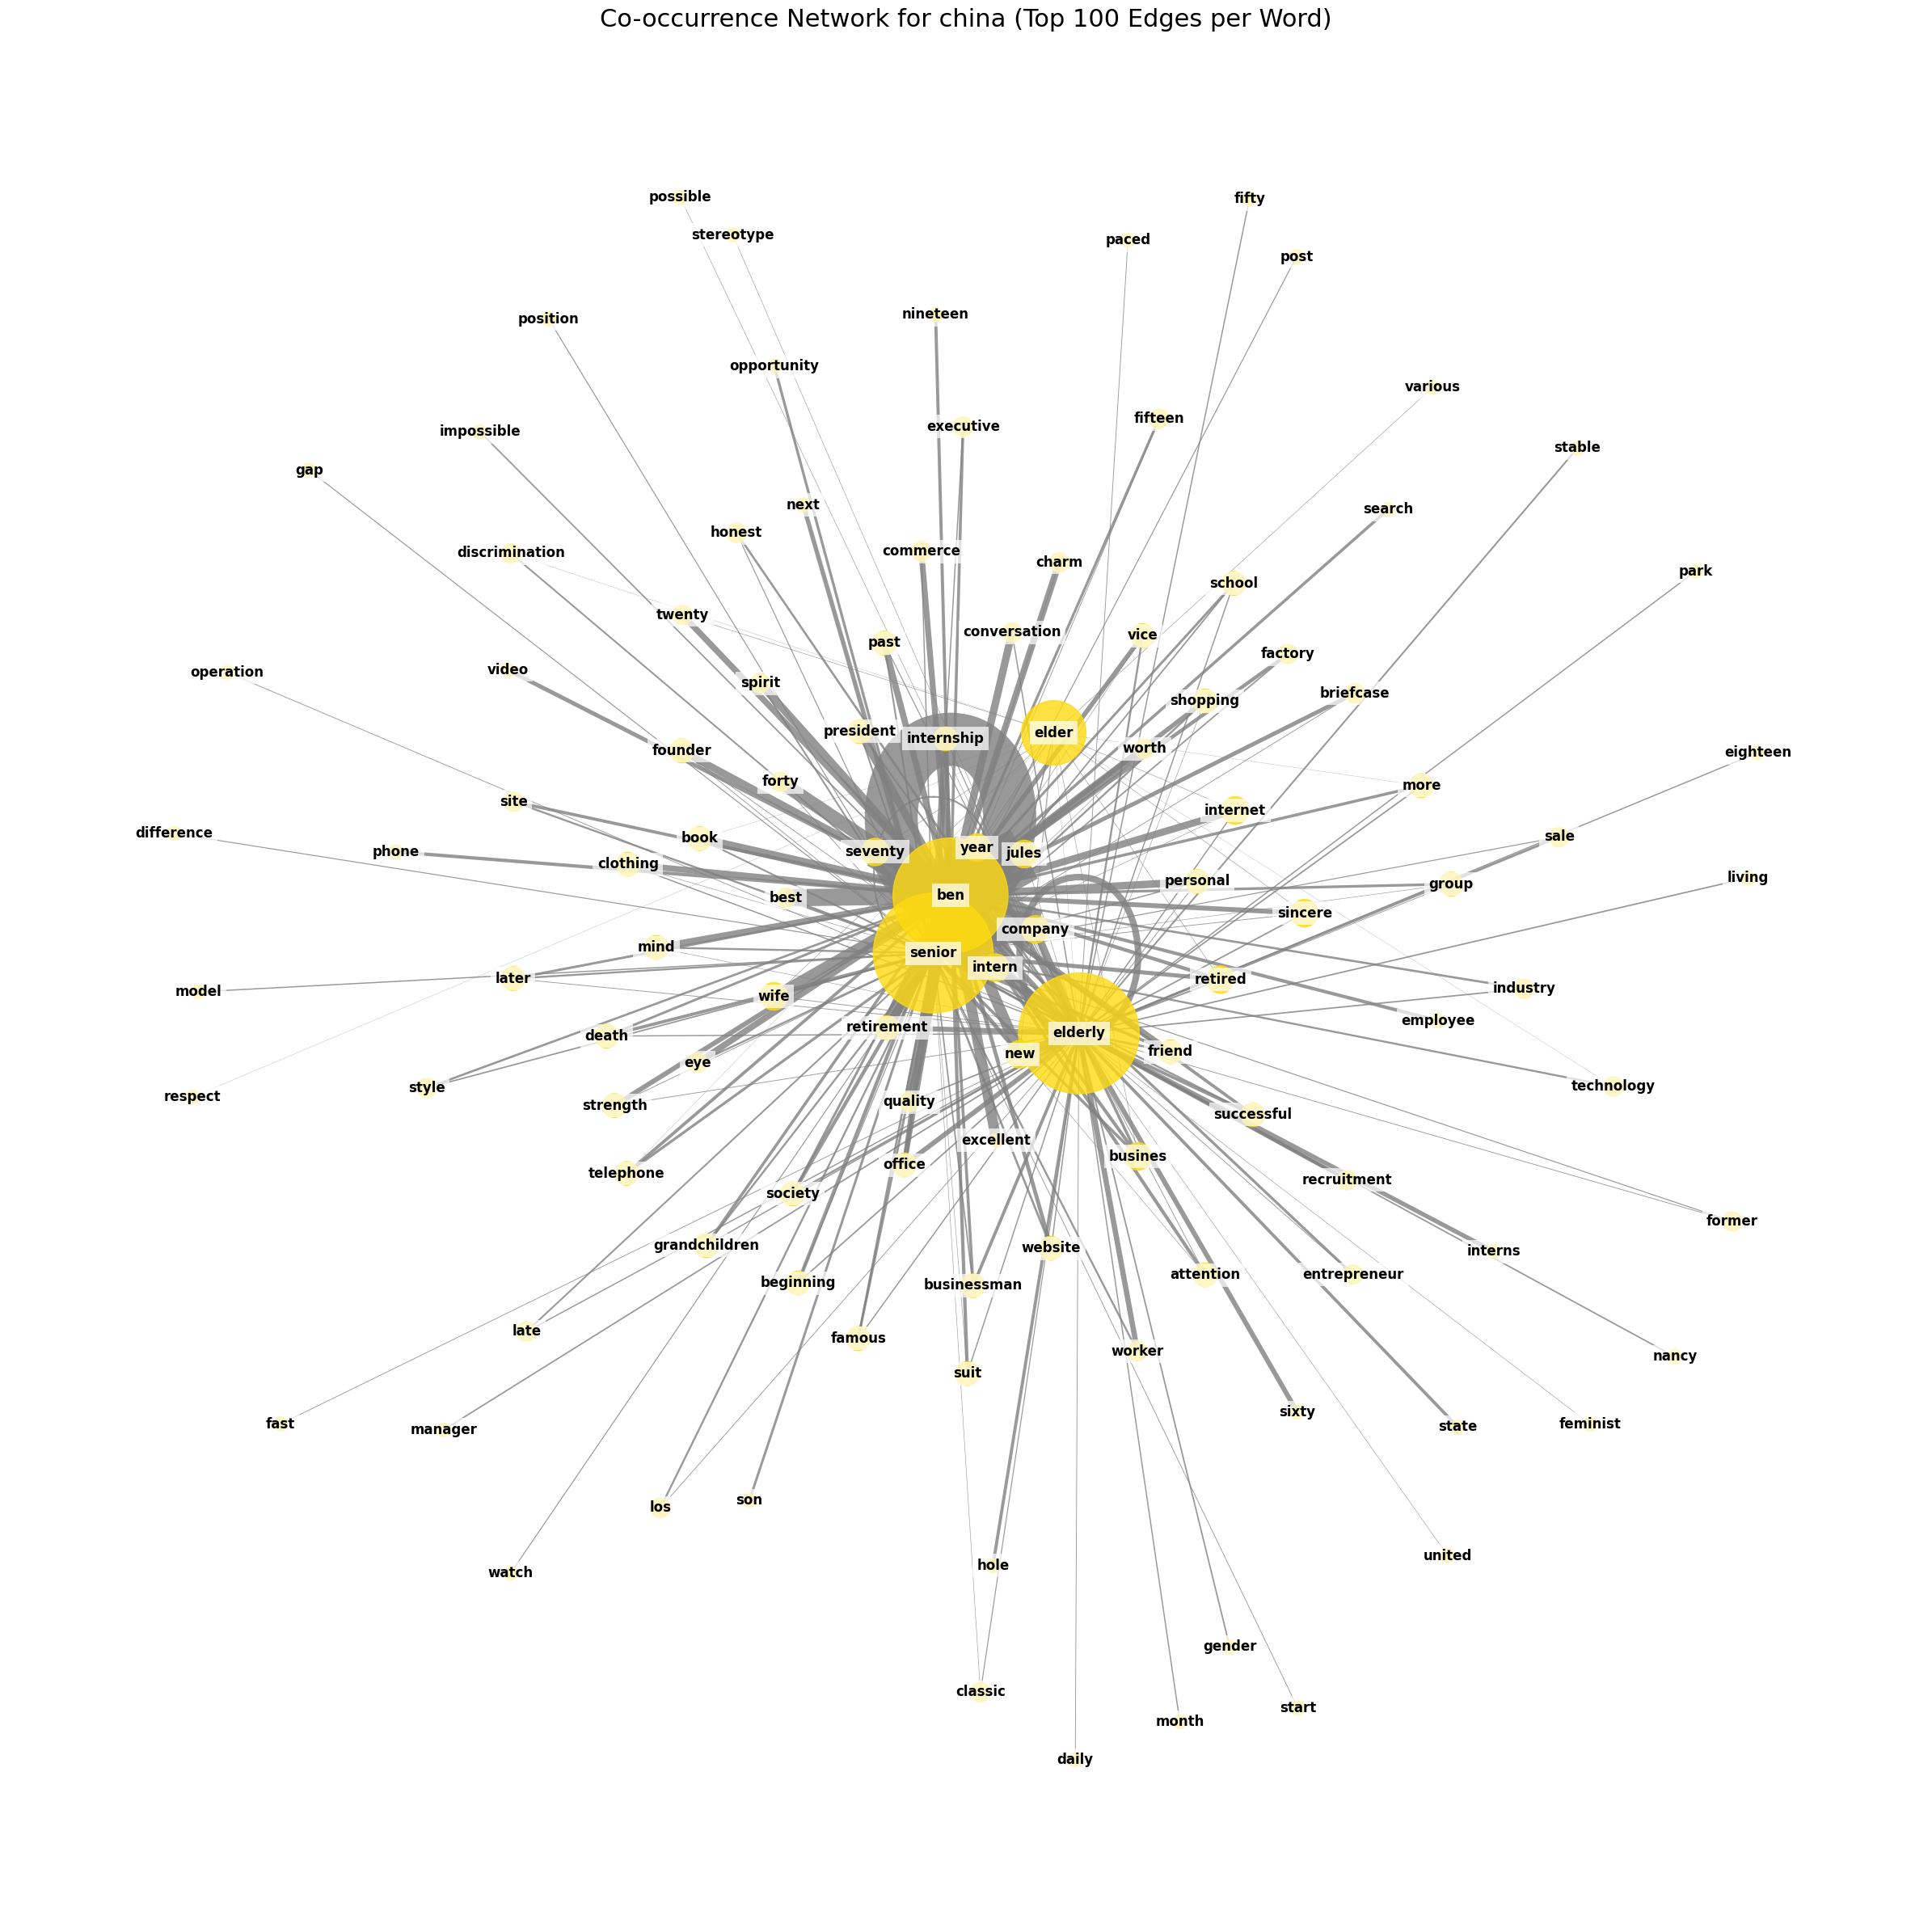

In [16]:
import itertools
from collections import defaultdict
import networkx as nx
import matplotlib.pyplot as plt

co_occurrence = defaultdict(int)
top_weight= 100
window_size = 20

for sentence in modified_sentences_filtered:
    effective_window_size = min(len(sentence), window_size)
    for i in range(len(sentence)):
        window = sentence[i:i+effective_window_size]
        for pair in itertools.combinations(window, 2):
            co_occurrence[pair] += 1
            
# Create the graph
G = nx.MultiGraph()

for (word1, word2), weight in co_occurrence.items():
    G.add_edge(word1, word2, weight=weight)


relevant_words = target_dict[target_country]['representative_words']

filtered_edges = [(u, v, d) for u, v, d in G.edges(data=True) if u in relevant_words or v in relevant_words]

H = nx.Graph()
H.add_edges_from(filtered_edges)

H_old_filtered = nx.Graph()

for word in relevant_words:
    edges_for_word = [(u, v, d) for u, v, d in G.edges(data=True) if (u == word or v == word)]
    sorted_edges = sorted(edges_for_word, key=lambda x: x[2]['weight'], reverse=True)[:top_weight]
    H_old_filtered.add_edges_from(sorted_edges)

# Visualization of the subgraph related to old words
plt.figure(figsize=(24,24))

# Adjust the spring layout for better node spacing
pos_old_filtered = nx.spring_layout(H_old_filtered, seed=42, k=1.2)

# Node sizes based on the number of edges (degree) connected to them
node_sizes = [H_old_filtered.degree(node) * 150 for node in H_old_filtered.nodes()]

# Node colors using HEX values (e.g., light blue)
node_colors = [f"#{target_dict[target_country]['color']}" for _ in H_old_filtered.nodes()]

# Draw edges with varying thickness based on weight
edge_weights = [d['weight'] for (u, v, d) in H_old_filtered.edges(data=True)]
max_weight = max(edge_weights)

normalized_weights = [50 * (w / max_weight) for w in edge_weights]

# Draw nodes, edges, and labels with improved readability
nx.draw_networkx_edges(H_old_filtered, pos_old_filtered, width=normalized_weights, alpha=0.8, edge_color='gray')
nx.draw_networkx_nodes(H_old_filtered, pos_old_filtered, node_size=node_sizes, node_color=node_colors, alpha=0.8)

# Add labels with a white background for better visibility
for node, (x, y) in pos_old_filtered.items():
    plt.text(x, y, node, fontsize=12, fontweight='bold', 
             ha='center', va='center', bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))

plt.title(f"Co-occurrence Network for {target_country} (Top {top_weight} Edges per Word)", fontsize=22)
plt.axis("off")
plt.tight_layout()
plt.show()